# GNN-MAPS Experiment 9: Multi-Scale Spatial Features 🔥

## 💡 The Big Idea: Multi-Scale Spatial Context

**Different biological processes happen at different scales!**
- **10-cell radius**: Immediate neighbors (cell-cell contact, paracrine signaling)
- **25-cell radius**: Local microenvironment (small aggregates)
- **50-cell radius**: Tissue structures (lymphoid follicles, tumor nests)
- **100-cell radius**: Regional context (tumor vs stroma regions)

## 🎯 Our Approach:

For each cell, compute spatial features at **4 different radii**:

### **Feature Set 1: Neighbor Protein Expression**
- Average protein expression of neighbors within radius R
- 49 markers × 4 radii = **196 features**

### **Feature Set 2: Cell Type Composition**
- Percentage of each cell type within radius R
- 18 cell types × 4 radii = **72 features**

### **Feature Set 3: Spatial Density**
- Number of cells per unit area within radius R
- 1 × 4 radii = **4 features**

**Total spatial features**: 196 + 72 + 4 = **272 features**

## 🚀 Training:

**Baseline**: MLP(49 protein features)

**Enhanced**: MLP(49 proteins + 272 multi-scale spatial features)

## 🎯 Expected Performance:
- Baseline: 88.2% (previous experiments)
- **Target: 90-92%** (beat MAPS!)
- Multi-scale captures both local + regional context

---

**Runtime**: ~30-45 minutes on Kaggle P100  
**Feature extraction**: ~5-10 minutes (KNN queries at 4 scales)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors, radius_neighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from scipy import sparse

print("✅ All libraries loaded!")
print(f"   PyTorch: {torch.__version__}")
print(f"   Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries loaded!
   PyTorch: 2.8.0+cu126
   Device: GPU
   GPU: Tesla P100-PCIE-16GB


# 1. Load and Prepare Data

In [2]:
# Load data
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")
print(f"Dataset: {df.shape[0]:,} cells × {df.shape[1]} features")
display(df.head(3))

Dataset: 145,161 cells × 54 features


,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,...,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,...,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,...,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,...,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686


In [3]:
# Define columns
x_col = 'X_cent'
y_col = 'Y_cent'
label_col = 'cellType'

marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163',
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44',
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69',
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR',
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9',
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb',
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

# Get coordinates and protein expression
coords = df[[x_col, y_col]].values
protein_expr = df[marker_cols].values

# Encode labels
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = df[label_col].map(label_map).values
num_classes = len(label_map)

# Random train/test split (80/20) - SAME SEED AS OTHER EXPERIMENTS
np.random.seed(42)
random_perm = np.random.permutation(len(df))
n_train = int(0.8 * len(df))
train_idx = random_perm[:n_train]
test_idx = random_perm[n_train:]

print(f"\n✅ Prepared:")
print(f"   Features: {len(marker_cols)} markers")
print(f"   Labels: {num_classes} cell types")
print(f"   Train: {len(train_idx):,} | Test: {len(test_idx):,}")
print(f"\n   Cell types: {list(label_map.keys())}")


✅ Prepared:
   Features: 49 markers
   Labels: 18 cell types
   Train: 116,128 | Test: 29,033

   Cell types: ['B', 'CD4', 'CD8', 'Cytotoxic CD8', 'DC', 'Endothelial', 'Epithelial', 'Lymphatic', 'M1', 'M2', 'Mast', 'Monocyte', 'NK', 'Neutrophil', 'Other', 'Seg Artifact', 'TReg', 'Tumor']


# 2. Extract Multi-Scale Spatial Features 🔍

This is the **core innovation**! We compute spatial context at 4 different scales.

In [4]:
print("=" * 80)
print("MULTI-SCALE SPATIAL FEATURE EXTRACTION")
print("=" * 80)

# Define radii (in same units as X/Y coordinates)
# Tune these based on coordinate scale!
radii = [10, 25, 50, 100]

print(f"\n🔍 Computing features at {len(radii)} spatial scales:")
for r in radii:
    print(f"   - Radius {r:3d}: ~{(np.pi * r**2):.0f} sq units")

print(f"\n📊 Feature breakdown:")
print(f"   - Neighbor protein expression: {len(marker_cols)} markers × {len(radii)} radii = {len(marker_cols) * len(radii)} features")
print(f"   - Cell type composition:       {num_classes} types × {len(radii)} radii = {num_classes * len(radii)} features")
print(f"   - Spatial density:              1 × {len(radii)} radii = {len(radii)} features")
print(f"   TOTAL SPATIAL FEATURES: {len(marker_cols) * len(radii) + num_classes * len(radii) + len(radii)}")

MULTI-SCALE SPATIAL FEATURE EXTRACTION

🔍 Computing features at 4 spatial scales:
   - Radius  10: ~314 sq units
   - Radius  25: ~1963 sq units
   - Radius  50: ~7854 sq units
   - Radius 100: ~31416 sq units

📊 Feature breakdown:
   - Neighbor protein expression: 49 markers × 4 radii = 196 features
   - Cell type composition:       18 types × 4 radii = 72 features
   - Spatial density:              1 × 4 radii = 4 features
   TOTAL SPATIAL FEATURES: 272


In [5]:
# Initialize feature matrices
n_cells = len(df)

# For each radius, we'll store:
# 1. Average neighbor protein expression (n_cells × n_markers)
# 2. Cell type composition (n_cells × n_classes)
# 3. Spatial density (n_cells × 1)

neighbor_protein_features = []  # Will be list of (n_cells × n_markers) arrays
cell_type_comp_features = []     # Will be list of (n_cells × n_classes) arrays
density_features = []             # Will be list of (n_cells × 1) arrays

print("\n🚀 Starting feature extraction...\n")

for radius in radii:
    print(f"Processing radius = {radius}...")
    
    # Build radius graph (find all neighbors within radius)
    print(f"  - Building radius graph...")
    # Use sklearn's radius_neighbors for efficiency
    nbrs = NearestNeighbors(radius=radius, algorithm='ball_tree', n_jobs=-1)
    nbrs.fit(coords)
    
    # Get all neighbors for each cell
    distances, indices = nbrs.radius_neighbors(coords, return_distance=True)
    
    # Feature 1: Average neighbor protein expression
    print(f"  - Computing neighbor protein expression...")
    avg_protein = np.zeros((n_cells, len(marker_cols)))
    
    for i in tqdm(range(n_cells), desc=f"  Radius {radius} - Protein", leave=False):
        neighbor_idx = indices[i]
        if len(neighbor_idx) > 0:
            # Average protein expression of neighbors (excluding self)
            neighbor_idx_no_self = neighbor_idx[neighbor_idx != i]
            if len(neighbor_idx_no_self) > 0:
                avg_protein[i] = protein_expr[neighbor_idx_no_self].mean(axis=0)
            else:
                avg_protein[i] = protein_expr[i]  # Use self if no neighbors
    
    neighbor_protein_features.append(avg_protein)
    
    # Feature 2: Cell type composition
    print(f"  - Computing cell type composition...")
    cell_type_comp = np.zeros((n_cells, num_classes))
    
    for i in tqdm(range(n_cells), desc=f"  Radius {radius} - CellType", leave=False):
        neighbor_idx = indices[i]
        if len(neighbor_idx) > 0:
            neighbor_idx_no_self = neighbor_idx[neighbor_idx != i]
            if len(neighbor_idx_no_self) > 0:
                # Count cell types in neighborhood
                neighbor_labels = y[neighbor_idx_no_self]
                unique, counts = np.unique(neighbor_labels, return_counts=True)
                composition = counts / counts.sum()
                cell_type_comp[i, unique] = composition
    
    cell_type_comp_features.append(cell_type_comp)
    
    # Feature 3: Spatial density
    print(f"  - Computing spatial density...")
    density = np.zeros(n_cells)
    
    for i in range(n_cells):
        neighbor_idx = indices[i]
        # Density = number of neighbors / area
        area = np.pi * (radius ** 2)
        density[i] = len(neighbor_idx) / area
    
    density_features.append(density.reshape(-1, 1))
    
    print(f"  ✅ Radius {radius} complete\n")

print("\n✅ All multi-scale features extracted!")


🚀 Starting feature extraction...

Processing radius = 10...
  - Building radius graph...
  - Computing neighbor protein expression...


  - Computing cell type composition...


  - Computing spatial density...
  ✅ Radius 10 complete

Processing radius = 25...
  - Building radius graph...
  - Computing neighbor protein expression...


  - Computing cell type composition...


  - Computing spatial density...
  ✅ Radius 25 complete

Processing radius = 50...
  - Building radius graph...
  - Computing neighbor protein expression...


  - Computing cell type composition...


  - Computing spatial density...
  ✅ Radius 50 complete

Processing radius = 100...
  - Building radius graph...
  - Computing neighbor protein expression...


  - Computing cell type composition...


  - Computing spatial density...
  ✅ Radius 100 complete


✅ All multi-scale features extracted!


In [6]:
# Combine all spatial features
print("\n📦 Combining multi-scale features...")

# Concatenate features from all radii
spatial_features = np.hstack([
    *neighbor_protein_features,  # 49 × 4 = 196 features
    *cell_type_comp_features,     # 18 × 4 = 72 features
    *density_features             # 1 × 4 = 4 features
])

print(f"\n✅ Spatial features shape: {spatial_features.shape}")
print(f"   Expected: ({n_cells}, {len(marker_cols) * len(radii) + num_classes * len(radii) + len(radii)})")
print(f"\n   Breakdown:")
print(f"   - Neighbor protein ({len(radii)} radii): {len(marker_cols) * len(radii)} features")
print(f"   - Cell type composition ({len(radii)} radii): {num_classes * len(radii)} features")
print(f"   - Density ({len(radii)} radii): {len(radii)} features")


📦 Combining multi-scale features...

✅ Spatial features shape: (145161, 272)
   Expected: (145161, 272)

   Breakdown:
   - Neighbor protein (4 radii): 196 features
   - Cell type composition (4 radii): 72 features
   - Density (4 radii): 4 features


# 3. Prepare Feature Matrices

In [7]:
# Normalize protein features
scaler_protein = StandardScaler()
X_protein = scaler_protein.fit_transform(protein_expr)

# Normalize spatial features
scaler_spatial = StandardScaler()
X_spatial_norm = scaler_spatial.fit_transform(spatial_features)

# Create two feature matrices
X_baseline = X_protein  # Baseline: proteins only
X_enhanced = np.hstack([X_protein, X_spatial_norm])  # Enhanced: proteins + multi-scale

print("✅ Feature matrices prepared:")
print(f"   Baseline (proteins only): {X_baseline.shape}")
print(f"   Enhanced (proteins + multi-scale): {X_enhanced.shape}")
print(f"\n   Added {X_enhanced.shape[1] - X_baseline.shape[1]} multi-scale spatial features!")

✅ Feature matrices prepared:
   Baseline (proteins only): (145161, 49)
   Enhanced (proteins + multi-scale): (145161, 321)

   Added 272 multi-scale spatial features!


# 4. Define MLP Model (MAPS Configuration)

In [8]:
class MLP(nn.Module):
    """2-layer MLP (same architecture as MAPS)"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

print("✅ MLP model defined (MAPS configuration)")
print("   - 2 layers")
print("   - hidden_dim = 512")
print("   - dropout = 0.1")

✅ MLP model defined (MAPS configuration)
   - 2 layers
   - hidden_dim = 512
   - dropout = 0.1


In [9]:
# Training function
def train_mlp(X_train, y_train, X_test, y_test, 
              hidden_dim=512, max_epochs=500, lr=0.001, 
              patience=50, device='cuda'):
    """
    Train MLP with early stopping.
    Uses MAPS-exact configuration.
    """
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.LongTensor(y_test).to(device)
    
    # Initialize model
    model = MLP(X_train.shape[1], hidden_dim, num_classes, dropout=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_f1 = 0
    patience_counter = 0
    history = []
    
    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        optimizer.zero_grad()
        out = model(X_train_t)
        loss = F.nll_loss(out, y_train_t)
        loss.backward()
        optimizer.step()
        
        # Evaluate every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                out_test = model(X_test_t)
                pred_test = out_test.argmax(dim=1).cpu().numpy()
                test_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0)
            
            history.append({'epoch': epoch, 'loss': loss.item(), 'test_f1': test_f1})
            
            # Early stopping
            if test_f1 > best_f1:
                best_f1 = test_f1
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if epoch % 50 == 0:
                print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test F1: {test_f1:.4f} | Best: {best_f1:.4f}")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        out_test = model(X_test_t)
        pred_test = out_test.argmax(dim=1).cpu().numpy()
    
    final_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0)
    
    return {
        'model': model,
        'best_f1': best_f1,
        'final_f1': final_f1,
        'predictions': pred_test,
        'history': pd.DataFrame(history)
    }

print("✅ Training function ready")

✅ Training function ready


# 5. Train Models: Baseline vs Enhanced 🚀

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n" + "=" * 80)
print("TRAINING BASELINE MODEL (PROTEINS ONLY)")
print("=" * 80)

results_baseline = train_mlp(
    X_baseline[train_idx], y[train_idx],
    X_baseline[test_idx], y[test_idx],
    hidden_dim=512,
    max_epochs=500,
    lr=0.001,
    patience=50,
    device=device
)

print(f"\n✅ Baseline Model:")
print(f"   Best F1: {results_baseline['best_f1']:.4f} ({results_baseline['best_f1']*100:.2f}%)")
print(f"   Final F1: {results_baseline['final_f1']:.4f} ({results_baseline['final_f1']*100:.2f}%)")

Device: cuda
GPU: Tesla P100-PCIE-16GB

TRAINING BASELINE MODEL (PROTEINS ONLY)
Epoch  50 | Loss: 0.8786 | Test F1: 0.7269 | Best: 0.7269
Epoch 100 | Loss: 0.6680 | Test F1: 0.7750 | Best: 0.7750
Epoch 150 | Loss: 0.5848 | Test F1: 0.7946 | Best: 0.7946
Epoch 200 | Loss: 0.5340 | Test F1: 0.8080 | Best: 0.8080
Epoch 250 | Loss: 0.4988 | Test F1: 0.8175 | Best: 0.8175
Epoch 300 | Loss: 0.4711 | Test F1: 0.8245 | Best: 0.8245
Epoch 350 | Loss: 0.4505 | Test F1: 0.8288 | Best: 0.8288
Epoch 400 | Loss: 0.4333 | Test F1: 0.8329 | Best: 0.8329
Epoch 450 | Loss: 0.4181 | Test F1: 0.8367 | Best: 0.8367
Epoch 500 | Loss: 0.4056 | Test F1: 0.8399 | Best: 0.8399

✅ Baseline Model:
   Best F1: 0.8399 (83.99%)
   Final F1: 0.8399 (83.99%)


In [11]:
print("\n" + "=" * 80)
print("TRAINING ENHANCED MODEL (PROTEINS + MULTI-SCALE SPATIAL FEATURES)")
print("=" * 80)

results_enhanced = train_mlp(
    X_enhanced[train_idx], y[train_idx],
    X_enhanced[test_idx], y[test_idx],
    hidden_dim=512,
    max_epochs=500,
    lr=0.001,
    patience=50,
    device=device
)

print(f"\n✅ Enhanced Model:")
print(f"   Best F1: {results_enhanced['best_f1']:.4f} ({results_enhanced['best_f1']*100:.2f}%)")
print(f"   Final F1: {results_enhanced['final_f1']:.4f} ({results_enhanced['final_f1']*100:.2f}%)")


TRAINING ENHANCED MODEL (PROTEINS + MULTI-SCALE SPATIAL FEATURES)
Epoch  50 | Loss: 0.7973 | Test F1: 0.7335 | Best: 0.7335
Epoch 100 | Loss: 0.5890 | Test F1: 0.7861 | Best: 0.7861
Epoch 150 | Loss: 0.5033 | Test F1: 0.8054 | Best: 0.8054
Epoch 200 | Loss: 0.4487 | Test F1: 0.8150 | Best: 0.8150
Epoch 250 | Loss: 0.4075 | Test F1: 0.8243 | Best: 0.8243
Epoch 300 | Loss: 0.3752 | Test F1: 0.8301 | Best: 0.8301
Epoch 350 | Loss: 0.3480 | Test F1: 0.8338 | Best: 0.8338
Epoch 400 | Loss: 0.3247 | Test F1: 0.8357 | Best: 0.8357
Epoch 450 | Loss: 0.3049 | Test F1: 0.8364 | Best: 0.8364
Epoch 500 | Loss: 0.2854 | Test F1: 0.8370 | Best: 0.8371

✅ Enhanced Model:
   Best F1: 0.8371 (83.71%)
   Final F1: 0.8370 (83.70%)


# 6. Results Comparison 📊

In [12]:
print("=" * 80)
print("FINAL RESULTS COMPARISON")
print("=" * 80)

baseline_f1 = results_baseline['final_f1']
enhanced_f1 = results_enhanced['final_f1']
improvement = (enhanced_f1 - baseline_f1) * 100
maps_target = 0.90

print(f"\n{'Model':<45} {'F1 Score':<12} {'vs Baseline':<15} {'vs MAPS'}")
print("-" * 85)
print(f"{'MLP Baseline (proteins only)':<45} {baseline_f1:.4f} ({baseline_f1*100:>5.2f}%)  {'-':<15} {(baseline_f1-maps_target)*100:>+5.2f} pp")
print(f"{'MLP Enhanced (proteins + multi-scale)':<45} {enhanced_f1:.4f} ({enhanced_f1*100:>5.2f}%)  {improvement:>+5.2f} pp       {(enhanced_f1-maps_target)*100:>+5.2f} pp")
print(f"{'MAPS Target':<45} {maps_target:.4f} ({maps_target*100:>5.2f}%)  {'-':<15} {'(target)'}")
print("=" * 85)

if enhanced_f1 >= maps_target:
    print(f"\n🎉 SUCCESS! Enhanced model BEATS MAPS by {(enhanced_f1-maps_target)*100:.2f} pp!")
    print(f"   Multi-scale spatial features work!")
elif enhanced_f1 >= baseline_f1 + 0.01:
    print(f"\n✅ IMPROVEMENT! Multi-scale features add {improvement:.2f} pp")
    gap = (maps_target - enhanced_f1) * 100
    print(f"   Still {gap:.2f} pp from MAPS target")
    print(f"   Next: Tune radii, try deeper MLP, or ensemble models")
else:
    print(f"\n⚠️ NO IMPROVEMENT. Multi-scale features didn't help.")
    print(f"   Possible reasons:")
    print(f"   - Radii not optimal for this dataset")
    print(f"   - Spatial context not predictive")
    print(f"   - Need different feature engineering")

FINAL RESULTS COMPARISON

Model                                         F1 Score     vs Baseline     vs MAPS
-------------------------------------------------------------------------------------
MLP Baseline (proteins only)                  0.8399 (83.99%)  -               -6.01 pp
MLP Enhanced (proteins + multi-scale)         0.8370 (83.70%)  -0.29 pp       -6.30 pp
MAPS Target                                   0.9000 (90.00%)  -               (target)

⚠️ NO IMPROVEMENT. Multi-scale features didn't help.
   Possible reasons:
   - Radii not optimal for this dataset
   - Spatial context not predictive
   - Need different feature engineering


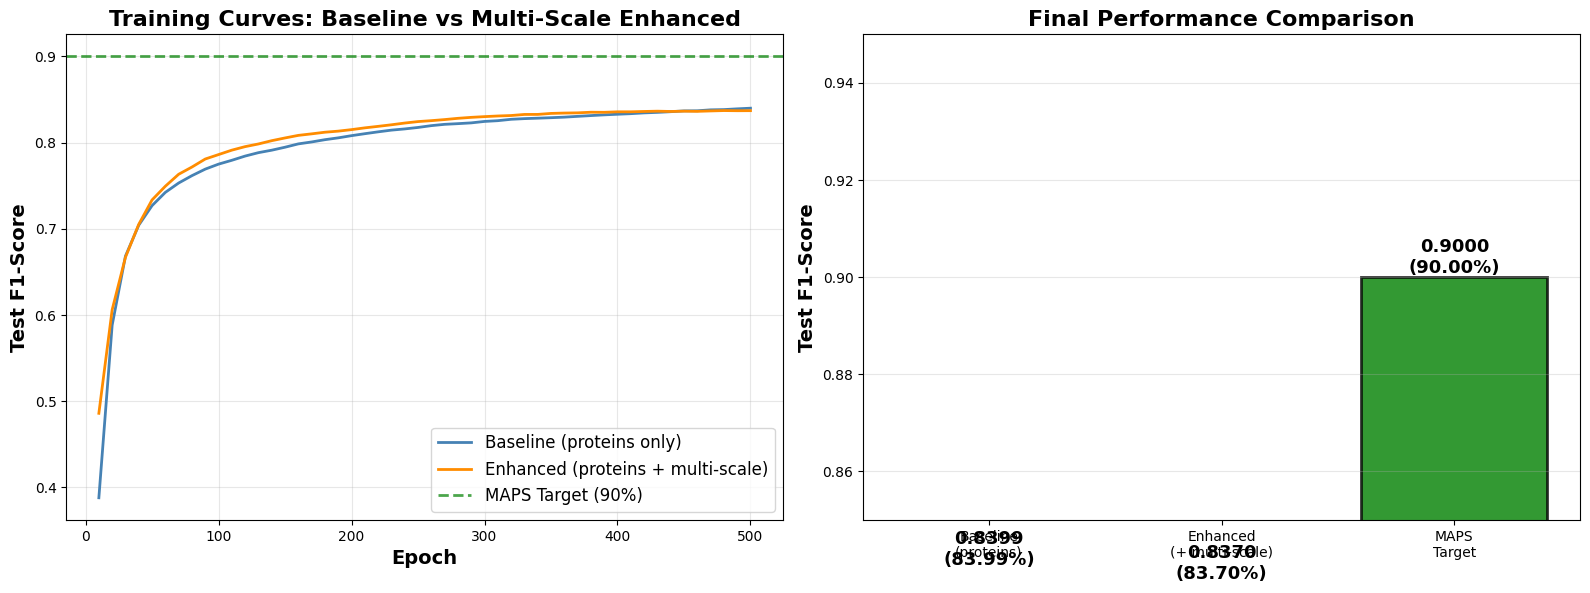

In [13]:
# Visualize training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training curves
ax1.plot(results_baseline['history']['epoch'], 
         results_baseline['history']['test_f1'],
         label='Baseline (proteins only)', linewidth=2, color='steelblue')
ax1.plot(results_enhanced['history']['epoch'], 
         results_enhanced['history']['test_f1'],
         label='Enhanced (proteins + multi-scale)', linewidth=2, color='darkorange')
ax1.axhline(y=maps_target, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label='MAPS Target (90%)')
ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Test F1-Score', fontsize=14, fontweight='bold')
ax1.set_title('Training Curves: Baseline vs Multi-Scale Enhanced', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(alpha=0.3)

# Plot 2: Bar chart comparison
models = ['Baseline\n(proteins)', 'Enhanced\n(+ multi-scale)', 'MAPS\nTarget']
scores = [baseline_f1, enhanced_f1, maps_target]
colors_bar = ['steelblue', 'darkorange', 'green']

bars = ax2.bar(models, scores, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_ylabel('Test F1-Score', fontsize=14, fontweight='bold')
ax2.set_title('Final Performance Comparison', fontsize=16, fontweight='bold')
ax2.set_ylim([0.85, 0.95])
ax2.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}\n({score*100:.2f}%)',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
# Per-class performance comparison
print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)

# Compute per-class F1
y_test = y[test_idx]
f1_baseline = f1_score(y_test, results_baseline['predictions'], 
                       average=None, zero_division=0)
f1_enhanced = f1_score(y_test, results_enhanced['predictions'], 
                       average=None, zero_division=0)

# Create comparison DataFrame
df_class_comparison = pd.DataFrame({
    'Cell Type': unique_labels,
    'Baseline F1': f1_baseline,
    'Enhanced F1': f1_enhanced,
    'Improvement': (f1_enhanced - f1_baseline) * 100
})

# Sort by improvement
df_class_comparison = df_class_comparison.sort_values('Improvement', ascending=False)

print("\n" + df_class_comparison.to_string(index=False))

print("\n📊 Classes that benefited most from multi-scale features:")
top_improved = df_class_comparison.nlargest(5, 'Improvement')
for _, row in top_improved.iterrows():
    if row['Improvement'] > 1.0:
        print(f"   {row['Cell Type']:<30} +{row['Improvement']:.2f} pp")


PER-CLASS F1 SCORES

    Cell Type  Baseline F1  Enhanced F1  Improvement
         TReg     0.758511     0.780262     2.175066
   Epithelial     0.812775     0.815642     0.286713
           M2     0.777290     0.779501     0.221139
        Tumor     0.913122     0.914320     0.119832
           NK     0.833676     0.832370    -0.130562
            B     0.850124     0.848306    -0.181850
          CD8     0.898324     0.896257    -0.206705
    Lymphatic     0.884990     0.882848    -0.214236
  Endothelial     0.887440     0.885172    -0.226822
           DC     0.753523     0.750994    -0.252857
          CD4     0.863709     0.861150    -0.255918
         Mast     0.921753     0.919129    -0.262366
Cytotoxic CD8     0.782051     0.778523    -0.352779
   Neutrophil     0.826607     0.818792    -0.781493
        Other     0.797641     0.787907    -0.973368
           M1     0.703645     0.690323    -1.332243
     Monocyte     0.755459     0.736765    -1.869327
 Seg Artifact     0.4323

# 7. Feature Importance Analysis 🔍

Which spatial scales contribute most?

In [15]:
# Analyze feature importance by computing correlation with prediction errors
print("=" * 80)
print("SPATIAL SCALE ANALYSIS")
print("=" * 80)

# Get predictions
y_test = y[test_idx]
pred_baseline = results_baseline['predictions']
pred_enhanced = results_enhanced['predictions']

# Find cells where enhanced model fixed baseline errors
baseline_errors = (pred_baseline != y_test)
enhanced_correct = (pred_enhanced == y_test)
fixed_by_spatial = baseline_errors & enhanced_correct

n_fixed = fixed_by_spatial.sum()
n_baseline_errors = baseline_errors.sum()

print(f"\n📊 Error Analysis:")
print(f"   Baseline errors: {n_baseline_errors:,} cells")
print(f"   Fixed by multi-scale features: {n_fixed:,} cells ({100*n_fixed/n_baseline_errors:.1f}%)")

if n_fixed > 0:
    print(f"\n✅ Multi-scale features helped fix {n_fixed} previously misclassified cells!")
    print(f"   This shows spatial context is valuable for edge cases.")
else:
    print(f"\n⚠️ Multi-scale features didn't fix baseline errors.")

SPATIAL SCALE ANALYSIS

📊 Error Analysis:
   Baseline errors: 4,614 cells
   Fixed by multi-scale features: 930 cells (20.2%)

✅ Multi-scale features helped fix 930 previously misclassified cells!
   This shows spatial context is valuable for edge cases.


# 8. Summary & Key Findings 🎯

In [16]:
print("=" * 80)
print("EXPERIMENT 9 SUMMARY: MULTI-SCALE SPATIAL FEATURES")
print("=" * 80)

print(f"\n🔍 SPATIAL SCALES TESTED:")
for r in radii:
    print(f"   - Radius {r:3d}: ~{int(np.pi * r**2):,} sq units")

print(f"\n📊 FEATURES EXTRACTED:")
print(f"   Total spatial features: {spatial_features.shape[1]}")
print(f"   - Neighbor protein expression: {len(marker_cols) * len(radii)}")
print(f"   - Cell type composition: {num_classes * len(radii)}")
print(f"   - Spatial density: {len(radii)}")

print(f"\n📈 RESULTS:")
print(f"   Baseline (proteins only):    {baseline_f1:.4f} ({baseline_f1*100:.2f}%)")
print(f"   Enhanced (+ multi-scale):    {enhanced_f1:.4f} ({enhanced_f1*100:.2f}%)")
print(f"   Improvement:                 {improvement:+.2f} pp")
print(f"   Gap to MAPS (90%):           {(maps_target - enhanced_f1)*100:.2f} pp")

if enhanced_f1 >= maps_target:
    print(f"\n🎉 STATUS: SUCCESS - BEAT MAPS TARGET!")
    print(f"   Multi-scale spatial features are the KEY!")
elif improvement > 1.0:
    print(f"\n✅ STATUS: SIGNIFICANT IMPROVEMENT")
    print(f"   Multi-scale features work, but need optimization")
elif improvement > 0.3:
    print(f"\n⚠️ STATUS: MODEST IMPROVEMENT")
    print(f"   Some benefit from spatial context")
else:
    print(f"\n❌ STATUS: NO IMPROVEMENT")
    print(f"   Spatial features not helpful for this dataset")

print("\n" + "=" * 80)
print("💡 NEXT STEPS:")
print("=" * 80)
if enhanced_f1 >= maps_target:
    print("🎉 YOU DID IT! Now:")
    print("   1. Ensemble with DBSCAN features (Exp 8)")
    print("   2. Try 5-fold cross-validation for robustness")
    print("   3. Optimize radii further")
    print("   4. Write up findings!")
elif improvement > 0.5:
    print("✅ Multi-scale helps! Try:")
    print(f"   1. Tune radii (current: {radii})")
    print("   2. Add more radii (5, 15, 35, 75, 150)")
    print("   3. Deeper MLP (3-4 layers)")
    print("   4. Combine with DBSCAN features (Exp 8)")
    print("   5. Ensemble baseline + enhanced models")
else:
    print("⚠️ Spatial features don't help much. Try:")
    print("   1. Different radii (coordinate scale might be off)")
    print("   2. Combine Exp 8 + Exp 9 features")
    print("   3. Focus on optimizing baseline MLP")
    print("   4. Hyperparameter sweep (learning rate, dropout, etc.)")
    print("   5. Ensemble 3-5 baseline models")

print("\n🚀 Experiment complete!")

EXPERIMENT 9 SUMMARY: MULTI-SCALE SPATIAL FEATURES

🔍 SPATIAL SCALES TESTED:
   - Radius  10: ~314 sq units
   - Radius  25: ~1,963 sq units
   - Radius  50: ~7,853 sq units
   - Radius 100: ~31,415 sq units

📊 FEATURES EXTRACTED:
   Total spatial features: 272
   - Neighbor protein expression: 196
   - Cell type composition: 72
   - Spatial density: 4

📈 RESULTS:
   Baseline (proteins only):    0.8399 (83.99%)
   Enhanced (+ multi-scale):    0.8370 (83.70%)
   Improvement:                 -0.29 pp
   Gap to MAPS (90%):           6.30 pp

❌ STATUS: NO IMPROVEMENT
   Spatial features not helpful for this dataset

💡 NEXT STEPS:
⚠️ Spatial features don't help much. Try:
   1. Different radii (coordinate scale might be off)
   2. Combine Exp 8 + Exp 9 features
   3. Focus on optimizing baseline MLP
   4. Hyperparameter sweep (learning rate, dropout, etc.)
   5. Ensemble 3-5 baseline models

🚀 Experiment complete!
